In [58]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.io import arff

# Implementation 

### LDA Implementation

In [2]:
class LDA:
    
    def __init__(self) -> None:
        self.sigma = None
        self.mu_0 = None
        self.mu_1 = None
        self.fraction_0 = None
        self.fraction_1 = None

    def fit(self, X, y):
        y = pd.DataFrame(y, columns=['y'])
        data = pd.concat([X, y], axis=1)
        data_0 = data[data['y'] == 0]
        data_1 = data[data['y'] == 1]
        data_0 = data_0.drop(columns='y')
        data_1 = data_1.drop(columns='y')
        data = data.drop(columns='y')

        self.sigma = data.cov()
        self.mu_0 = data_0.mean()
        self.mu_1 = data_1.mean()
        self.fraction_0 = len(data_0) / len(data)
        self.fraction_1 = len(data_1) / len(data)

    def gaussian(self, x, mu, sigma):
        n = len(x)
        det = np.linalg.det(sigma)
        inv = np.linalg.inv(sigma)
        x_mu = (x - mu)
        result = 1 / (np.power(2 * pi, n / 2) * np.power(det, 0.5)) * np.exp(-0.5 * (x_mu.T @ inv @ x_mu))
        return result

    def predict_proba(self, X_test):
        probabilities = []
        for _, row in X_test.iterrows():
            numerator = self.fraction_1 * self.gaussian(row, self.mu_1, self.sigma)
            denominator = self.fraction_1 * self.gaussian(row, self.mu_1, self.sigma) + self.fraction_0 * self.gaussian(row, self.mu_0, self.sigma)
            probabilities.append(numerator / denominator)
        return probabilities


    def predict(self, X_test):
        X_test_copy = X_test.copy()
        X_test_copy["predicted_proba"] = self.predict_proba(X_test)
        X_test_copy["y_pred"] = 0
        X_test_copy.loc[X_test_copy["predicted_proba"] > 0.5, "y_pred"] = 1
        return X_test_copy['y_pred']
    

    def return_params(self):
        return {"covariance matrix": self.sigma,
                 "mean for class 0": self.mu_0, "mean for class 1": self.mu_1}
    
    def calculate_decision_boundary_params(self):
        sigma_inv = np.linalg.inv(self.sigma)
        a = sigma_inv @ (self.mu_1 - self.mu_0)
        b = -0.5 * (self.mu_1.T @ sigma_inv @ self.mu_1 - self.mu_0.T @ sigma_inv @ self.mu_0) + np.log(self.fraction_1 / self.fraction_0)
        return a, b
    

### QDA Implementation

In [3]:
class QDA:
    def __init__(self) -> None:
        self.sigma_0 = None
        self.sigma_1 = None
        self.mu_0 = None
        self.mu_1 = None
        self.fraction_0 = None
        self.fraction_1 = None

    def fit(self, X, y):
        y = pd.DataFrame(y, columns=['y'])
        data = pd.concat([X, y], axis=1)
        data_0 = data[data['y'] == 0]
        data_1 = data[data['y'] == 1]
        data_0 = data_0.drop(columns='y')
        data_1 = data_1.drop(columns='y')

        self.sigma_0 = data_0.cov()
        self.sigma_1 = data_1.cov()
        self.mu_0 = data_0.mean()
        self.mu_1 = data_1.mean()
        self.fraction_0 = len(data_0) / len(data)
        self.fraction_1 = len(data_1) / len(data)

    def gaussian(self, x, mu, sigma):
        n = len(x)
        det = np.linalg.det(sigma)
        inv = np.linalg.inv(sigma)
        x_mu = (x - mu)
        result = 1 / (np.power(2 * pi, n / 2) * np.power(det, 0.5)) * np.exp(-0.5 * (x_mu.T @ inv @ x_mu))
        return result

    def predict_proba(self, X_test):
        probabilities = []
        for _, row in X_test.iterrows():
            numerator = self.fraction_1 * self.gaussian(row, self.mu_1, self.sigma_1)
            denominator = self.fraction_1 * self.gaussian(row, self.mu_1, self.sigma_1) + self.fraction_0 * self.gaussian(row, self.mu_0, self.sigma_0)
            probabilities.append(numerator / denominator)
        return probabilities


    def predict(self, X_test):
        X_test_copy = X_test.copy()
        X_test_copy["predicted_proba"] = self.predict_proba(X_test)
        X_test_copy["y_pred"] = 0
        X_test_copy.loc[X_test_copy["predicted_proba"] > 0.5, "y_pred"] = 1
        return X_test_copy['y_pred']
    

    def return_params(self):
        return {"covariance matrix for class 0": self.sigma_0, "covariance matrix for class 1" :self.sigma_1,
                 "mean for class 0": self.mu_0, "mean for class 1": self.mu_1}
    
    def calculate_decision_boundary_params(self):
        sigma_0_inv = np.linalg.inv(self.sigma_0)
        sigma_1_inv = np.linalg.inv(self.sigma_1)
        a = -0.5 * sigma_0_inv + 0.5 * sigma_1_inv
        b = sigma_1_inv @ self.mu_1 - sigma_0_inv @ self.mu_0
        c = 0.5 * (self.mu_0.T @ sigma_0_inv @ self.mu_0 - self.mu_1.T @ sigma_1_inv @ self.mu_1) + np.log(self.fraction_1 / self.fraction_0) - 0.5 * np.log(np.linalg.det(self.sigma_0) / np.linalg.det(self.sigma_1))

        return a,b,c 

### Naive Bayes Implementation

In [4]:
class NB:
    """
    Naive Bayes classifier implementation. Naive Bayes assumes that the features are conditionally independent given the class. 
    This results in a diagonal covariance matrix for each class. 

    Attributes:
        sigma_0 (ndarray): Covariance matrix (diagonal) for class 0.
        sigma_1 (ndarray): Covariance matrix (diagonal) for class 1.
        mu_0 (Series): Mean vector for class 0.
        mu_1 (Series): Mean vector for class 1.
        fraction_0 (float): Fraction of samples belonging to class 0.
        fraction_1 (float): Fraction of samples belonging to class 1.

    Methods:
        fit(X, y): Fit the Naive Bayes classifier to the training data.
        gaussian(x, mu, sigma): Compute the Gaussian probability density function.
        predict_proba(X_test): Predict the class probabilities for the test data.
        predict(X_test): Predict the class labels for the test data.
        return_params(): Return the parameters of the Naive Bayes classifier.
    """
    
    def __init__(self) -> None:
        self.sigma_0 = None
        self.sigma_1 = None
        self.mu_0 = None
        self.mu_1 = None
        self.fraction_0 = None
        self.fraction_1 = None

    def fit(self, X, y):
        """
        Fit the Naive Bayes classifier to the training data.

        Args:
            X (DataFrame): Training data features.
            y (array-like): Training data labels.
        """
        y = pd.DataFrame(y, columns=['y'])
        data = pd.concat([X, y], axis=1)
        data_0 = data[data['y'] == 0]
        data_1 = data[data['y'] == 1]
        data_0 = data_0.drop(columns='y')
        data_1 = data_1.drop(columns='y')

        self.sigma_0 = np.diag(np.diag(data_0.cov()))
        self.sigma_1 = np.diag(np.diag(data_1.cov()))
        self.mu_0 = data_0.mean()
        self.mu_1 = data_1.mean()
        self.fraction_0 = len(data_0) / len(data)
        self.fraction_1 = len(data_1) / len(data)
        

    def gaussian(self, x, mu, sigma):
        """
        Compute the Gaussian probability density function.

        Args:
            x (ndarray): Input vector.
            mu (Series): Mean vector.
            sigma (ndarray): Covariance matrix (diagonal).

        Returns:
            ndarray: Gaussian probability density values.
        """
        n = len(x)
        det = np.linalg.det(sigma)
        inv = np.linalg.inv(sigma)
        x_mu = (x - mu)
        result = 1 / (np.power(2 * pi, n / 2) * np.power(det, 0.5)) * np.exp(-0.5 * (x_mu.T @ inv @ x_mu))
        return result

    def predict_proba(self, X_test):
        """
        Predict the class probabilities for the test data.

        Args:
            X_test (DataFrame): Test data features.

        Returns:
            ndarray: Predicted class probabilities.
        """
        probabilities = []
        for _, row in X_test.iterrows():
            numerator = self.fraction_1 * self.gaussian(row, self.mu_1, self.sigma_1)
            denominator = self.fraction_1 * self.gaussian(row, self.mu_1, self.sigma_1) + self.fraction_0 * self.gaussian(row, self.mu_0, self.sigma_0)
            probabilities.append(numerator / denominator)
        return probabilities


    def predict(self, X_test):
        """
        Predict the class labels for the test data.

        Args:
            X_test (DataFrame): Test data features.

        Returns:
            Series: Predicted class labels.
        """
        X_test_copy = X_test.copy()
        X_test_copy["predicted_proba"] = self.predict_proba(X_test)
        X_test_copy["y_pred"] = 0
        X_test_copy.loc[X_test_copy["predicted_proba"] > 0.5, "y_pred"] = 1
        return X_test_copy['y_pred']


    def return_params(self):
        """
        Return the parameters of the Naive Bayes classifier.

        Returns:
            dict: Parameters of the Naive Bayes classifier.
        """
        return {"covariance matrix for class 0": self.sigma_0, "covariance matrix for class 1" :self.sigma_1,
                 "mean for class 0": self.mu_0, "mean for class 1": self.mu_1}
    

## Testing implementation

In [32]:
lda = LDA()
X = pd.DataFrame({'x1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11], 'x2': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]})
y = pd.Series([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
lda.fit(X, y)


print(lda.predict_proba(X))
print(lda.predict(X))
param = lda.return_params()

for key, value in param.items():
    print(f"{key}\n{value}\n")

covar = param['covariance matrix']
np.diag(np.diag(covar))

[0.06913842034334466, 0.11920292202211673, 0.19781611144141412, 0.31002551887238583, 0.4501660026875202, 0.5986876601124512, 0.731058578630004, 0.8320183851339261, 0.9002495108803144, 0.8581489350995195]
0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    1
8    1
9    1
Name: y_pred, dtype: int64
covariance matrix
           x1        x2
x1  10.266667 -9.666667
x2  -9.666667  9.166667

mean for class 0
x1    3.0
x2    8.0
dtype: float64

mean for class 1
x1    8.2
x2    3.0
dtype: float64



array([[10.26666667,  0.        ],
       [ 0.        ,  9.16666667]])

# Comparison of LDA, QDA and NB methods on simulated data

### Generating datasets

In [6]:
def generate_data(a, ro=0, n_samples=1000):
    """
    Generate synthetic data for binary classification. 
    When ro == 0 generates data with scheme 1. When ro != 0 generates data with scheme 2.
    
    Parameters:
    a (float): Mean value for the positive class.
    ro (float, optional): Covariance between features. Defaults to 0.
    n_samples (int, optional): Number of samples to generate. Defaults to 1000.
    
    Returns:
    pd.DataFrame: Generated synthetic data with features 'x1', 'x2' and target variable 'y'.
    """
    
    y = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])
    number_of_ones = len(y[y == 1])
    number_of_zeros = len(y[y == 0])
    df_zeros = pd.DataFrame(np.random.multivariate_normal(mean = [0, 0], cov = [[1, ro], [ro, 1]], size = number_of_zeros), columns=['x1', 'x2'])
    df_ones = pd.DataFrame(np.random.multivariate_normal(mean = [a, a], cov = [[1, -ro], [-ro, 1]], size = number_of_ones), columns=['x1', 'x2'])
    df_zeros['y'] = 0
    df_ones['y'] = 1
    df = pd.concat([df_zeros, df_ones], axis=0)
    return df.sample(frac=1).reset_index(drop=True)


##### Helper functions

In [7]:
def calculate_accuracy(df, split_ratio, method, random_state):
    y = df['y']
    X = df.drop(columns='y')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=random_state)

    # fit the model
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [43]:
def compare_methods(a, ro, repetitions, methods):

    data_frame = pd.DataFrame(columns=['mean', 'method', 'accuracy', 'covariance'])
    for mean in a:
        for cov in ro:
            df = generate_data(mean, cov)
            for i in range(repetitions):
                random_state = np.random.randint(0, 100000)
                for method in methods:
                        accuracy = calculate_accuracy(df, 0.8, methods[method], random_state)
                        data_frame.loc[len(data_frame.index)] = [mean, method, accuracy, cov] 
    return data_frame

### Comparing methods with different mean 

##### Scheme 1

Text(0.5, 1.0, 'Comparison of LDA, QDA and Naive Bayes for different means, based on 100 80/20 split, uncorrelated features (scheme 1)')

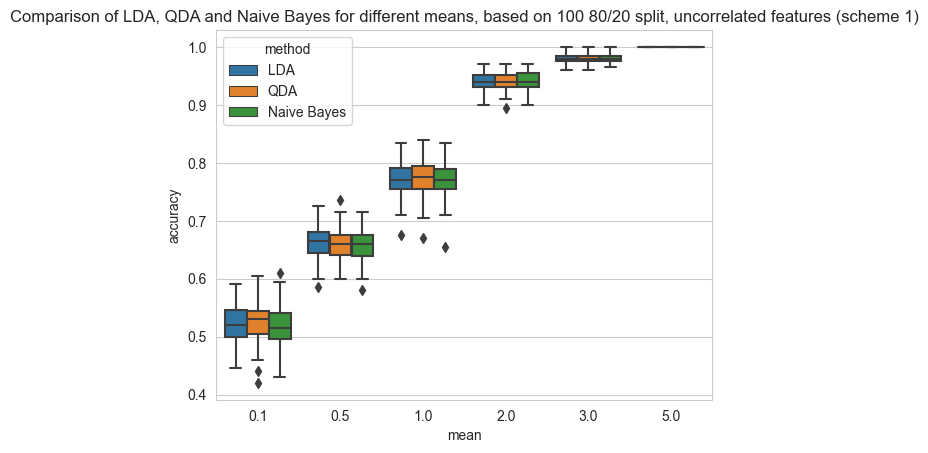

In [38]:
# parameters
ro = [0]
a = [0.1, 0.5, 1, 2, 3, 5]
methods = {'LDA': LDA(), 'QDA': QDA(), 'Naive Bayes': NB()}
repetitions = 100

data_frame = compare_methods(a, ro, repetitions, methods)
sns.set_style("whitegrid") 
sns.boxplot(x = 'mean', y = 'accuracy', data = data_frame, hue='method') 
plt.title('Comparison of LDA, QDA and Naive Bayes for different means, based on 100 80/20 split, uncorrelated features (scheme 1)')

##### Scheme 2

Text(0.5, 1.0, 'Comparison of LDA, QDA and Naive Bayes for different means, based on 100 80/20 split, correlated features with ro = 0.5 (scheme 2)')

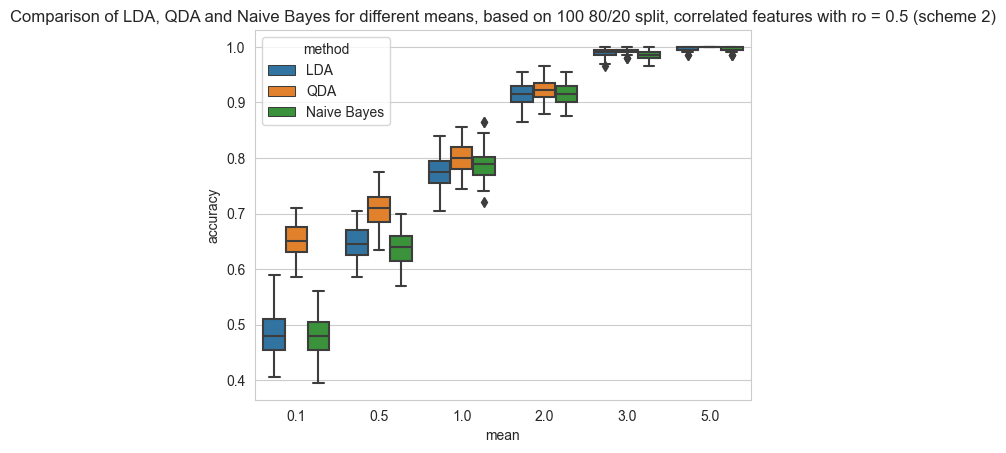

In [39]:
# parameters
ro = [0.5]
a = [0.1, 0.5, 1, 2, 3, 5]
methods = {'LDA': LDA(), 'QDA': QDA(), 'Naive Bayes': NB()}
repetitions = 100

data_frame = compare_methods(a, ro, repetitions, methods)
sns.set_style("whitegrid") 
sns.boxplot(x = 'mean', y = 'accuracy', data = data_frame, hue='method') 
plt.title('Comparison of LDA, QDA and Naive Bayes for different means, based on 100 80/20 split, correlated features with ro = 0.5 (scheme 2)')

### Comparing methods with different covariance 

##### Scheme 1

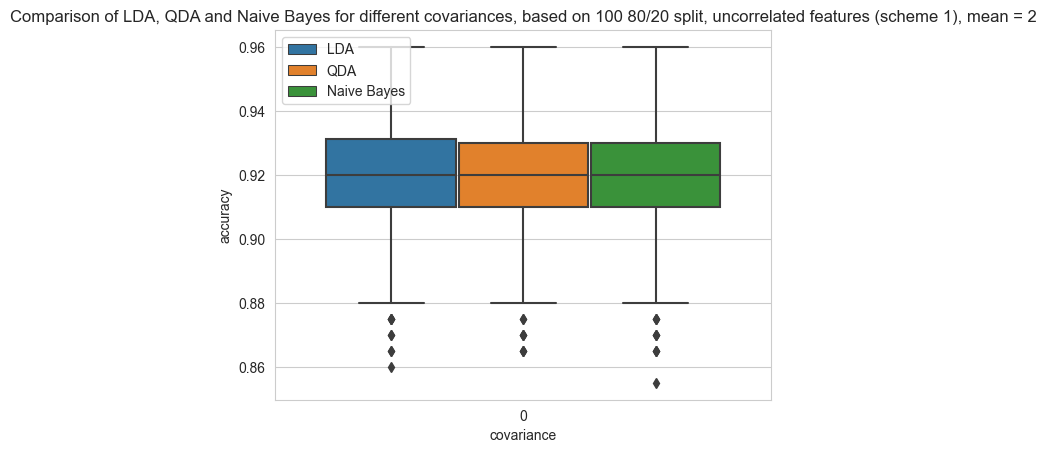

In [46]:
# parameters
ro = [0, 0, 0, 0, 0, 0]
a = [2]
methods = {'LDA': LDA(), 'QDA': QDA(), 'Naive Bayes': NB()}
repetitions = 100

data_frame = compare_methods(a, ro, repetitions, methods)
sns.set_style("whitegrid") 
sns.boxplot(x = 'covariance', y = 'accuracy', data = data_frame, hue='method') 
plt.title('Comparison of LDA, QDA and Naive Bayes for different covariances, based on 100 80/20 split, uncorrelated features (scheme 1), mean = 2')
plt.legend(loc='upper left')

##### Scheme 2

Text(0.5, 1.0, 'Comparison of LDA, QDA and Naive Bayes for different covariances, based on 100 80/20 split, correlated features with varying ro (scheme 2), mean = 2')

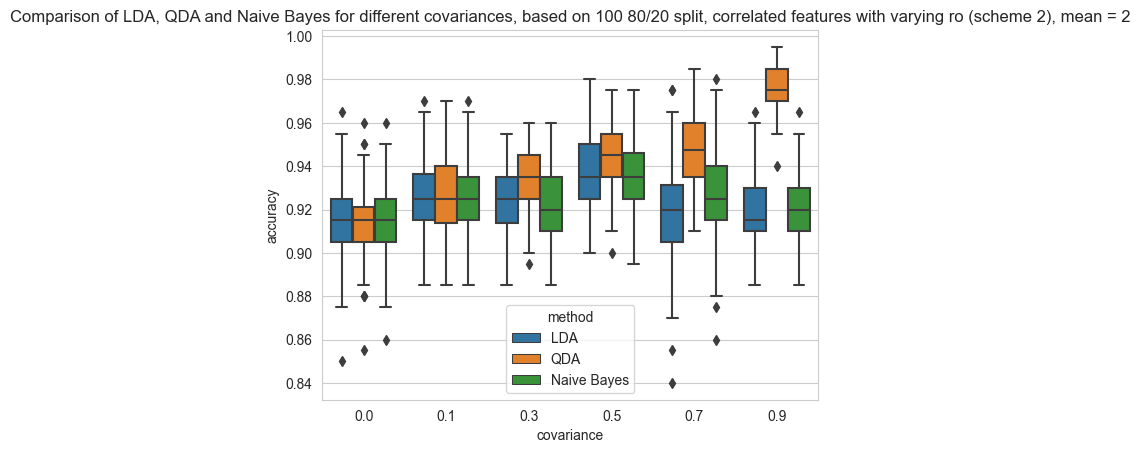

In [44]:
# parameters
ro = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
a = [2]
methods = {'LDA': LDA(), 'QDA': QDA(), 'Naive Bayes': NB()}
repetitions = 100

data_frame = compare_methods(a, ro, repetitions, methods)
sns.set_style("whitegrid") 
sns.boxplot(x = 'covariance', y = 'accuracy', data = data_frame, hue='method') 
plt.title('Comparison of LDA, QDA and Naive Bayes for different covariances, based on 100 80/20 split, correlated features with varying ro (scheme 2), mean = 2')

### Generating scatter plots

In [9]:
def generate_scatter_plot(train, test, title):
    """
    Generate scatter plot for the given data.
    """
    lda = LDA()
    lda.fit(train.drop(columns='y'), train['y'])
    lda_boundary_params = lda.calculate_decision_boundary_params()

    qda = QDA()
    qda.fit(train.drop(columns='y'), train['y'])
    qda_params = qda.calculate_decision_boundary_params()

    train["split"] = "train"
    test["split"] = "test"
    data = pd.concat([train, test], axis=0)
    sns.scatterplot(data=data, x='x1', y='x2', hue='y',style="split", markers=["o", "X"], palette="Set1")

    x = np.linspace(data['x1'].min(), data['x1'].max(), 100)
    y = np.linspace(data['x2'].min(), data['x2'].max(), 100)
    X, Y = np.meshgrid(x, y)

    # LDA decision boundary
    a, b = lda_boundary_params
    Z = a[0] * X + a[1] * Y + b
    plt.contour(X, Y, Z, levels=[0], colors='green')
    
    # QDA decision boundary
    a, b, c = qda_params

    Z = a[0, 0] * X**2 + (a[0, 1] + a[1, 0]) * X * Y + a[1, 1] * Y**2 + b[0] * X + b[1] * Y + c
    plt.contour(X, Y, Z, levels=[0], colors='red')
    
    
    plt.title(title)
    plt.show()

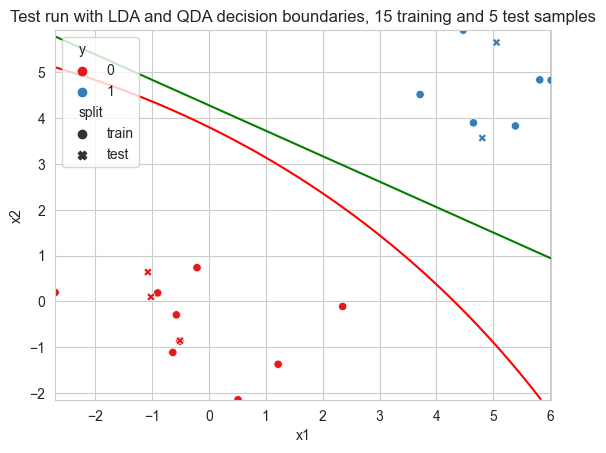

In [54]:
df = generate_data(4, 0,20)
train = df.iloc[:15]
test = df.iloc[15:]
generate_scatter_plot(train, test, 'Test run with LDA and QDA decision boundaries, 15 training and 5 test samples')

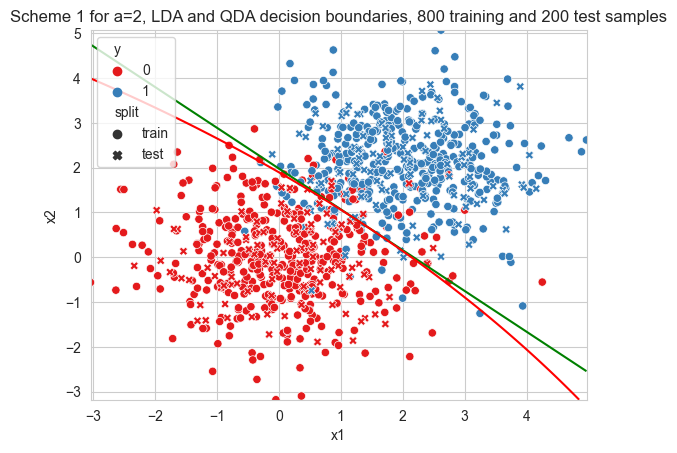

In [56]:
df = generate_data(2, 0)
train = df.iloc[:800]
test = df.iloc[800:]
generate_scatter_plot(train, test, 'Scheme 1 for a=2, LDA and QDA decision boundaries, 800 training and 200 test samples')

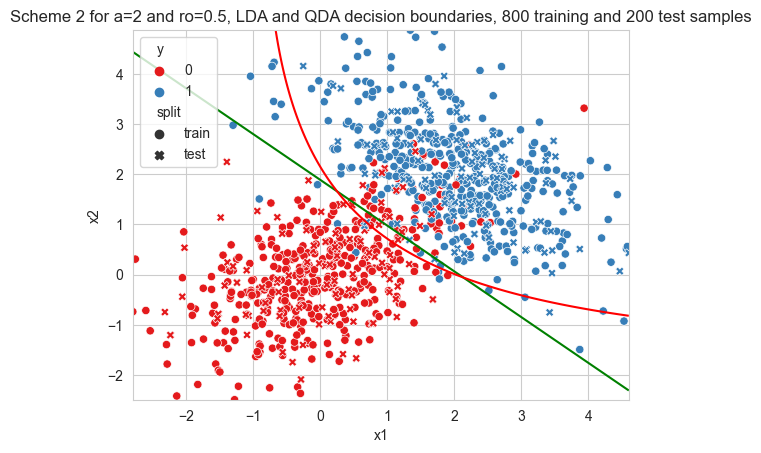

In [57]:
df = generate_data(2, 0.5)
train = df.iloc[:800]
test = df.iloc[800:]
generate_scatter_plot(train, test, 'Scheme 2 for a=2 and ro=0.5, LDA and QDA decision boundaries, 800 training and 200 test samples') 

# Comparison of LDA, QDA and NB on real data

## First set 

[Data](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&id=37) - Pima Indians Diabetes Database

class value 1 is interpreted as "tested positive for diabetes"

## Second set 

[Data](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&id=1471) - EEG measurement with the Emotiv EEG Neuroheadset

The eye state was detected via a camera during the EEG measurement and added later manually to the file after analyzing the video frames. '1' indicates the eye-closed and '0' the eye-open state.

## Third set 

[Data](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&id=1464) - Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan

The target attribute is a binary variable representing whether he/she donated blood in March 2007 